# The K-profile parameterization in `OceanTurb.jl`

Here we demonstrate how to set up a `Model` in `OceanTurb.jl`, set initial conditions and boundary conditions, and iterate the model forward.

In [1]:
using Pkg; Pkg.activate(".."); Pkg.instantiate()
using OceanTurb, OceanTurb.Plotting, PyPlot, Printf

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


# Free convection

Next, we write a function that sets up a 'free convection' problem.

Free convection is characterized

* a constant flux boundary condition for temperature at the top (`buoyancy_flux`)
* a stable, linear temperature initial condition (`γ`)
* zero initial conditions for other variables

In addition, we allow the user to set the resolution, domain size, and model parameters.
We use Backward Euler timestepping.

In [2]:
function free_convection_model(; N=200, L=20, γ=0.01, buoyancy_flux=1e-8, parameters=KPP.Parameters())
    
    model = KPP.Model(N=N, L=L, parameters=parameters, stepper=:BackwardEuler)

    # Initial condition
    γ = 0.01
    T₀(z) = 20 + γ*z
    
    # Set T to the function T0(z)
    model.solution.T = T₀

    temperature_flux = buoyancy_flux / (model.constants.α * model.constants.g)
    model.bcs.T.top = FluxBoundaryCondition(temperature_flux)
    model.bcs.T.bottom = GradientBoundaryCondition(γ)
    
    return model
end

free_convection_model (generic function with 1 method)

# The 'Van Roekel' example

[Van Roekel et al (2018)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018MS001336)
compares the KPP of Large et al. 1994 to a large eddy simulation of free convection with a heat flux of 75 $\mathrm{W \, m^{-2}}$.

They report in their equation F11 that in pure convection the mixing layer should deepen according to

$$ h(t) = \sqrt{ \frac{2.8 F_b t}{N^2} } $$

where $F_b$ is the surface buoyancy flux and $N^2 = B_z(t=0)$ is the initial buoyancy gradient.

In [3]:
# First, let's use the default model
c = OceanTurb.Constants()
γ = 0.01
heat_flux = 75
v18_buoyancy_flux = c.α * c.g * heat_flux / (c.ρ₀ * c.cP)

model = free_convection_model(γ=γ, buoyancy_flux=v18_buoyancy_flux)

# Time stepping
dt = 60 # seconds
nt = ceil(Int, 3600 / dt) # plot every hour
ni = 10

# Keep track of boundary layer depth versus time
h = [0.0]
t = [0.0]

# Re-initialize plotting and iterating
fig, axs = subplots(ncols=2, sharey=true)

U, V, T, S = model.solution
Tz = ∂z(T)
reset!(model.clock)

sca(axs[1])
ylim(-20, 0)
xlim(19.8, 20)
xlabel(L"T")
ylabel(L"z")
removespines("top", "right")

plot(T, "--", label="initial condition")

sca(axs[2])
xlim(-0.05, 0.05)
removespines("left", "top", "right")
axs[2].tick_params(left=false, labelleft=false)
xlabel(L"\partial_z T")

plot(Tz, "--", label="initial condition")

# Iterate
for i = 1:ni
    iterate!(model, dt, nt)
    
    push!(h, model.state.h)
    push!(t, time(model))
    
    @printf("t: %.2f minutes, mixing layer depth: %.2f\n", time(model)/60, model.state.h)
  
    ∂z!(Tz, T)
    
    sca(axs[1])
    plot(T, "-")
    plot(top(T), -model.state.h, "k.")
    
    sca(axs[2])
    plot(Tz, "-")
end

fig, axs= subplots()

removespines("top", "right")
xlabel("\$t\$ (hours)")
ylabel("Mixing layer depth, \$h\$ (m)")

@show v18_buoyancy_flux
@show v18_N₀ = sqrt(c.g * c.α * γ) v18_N₀^2
@show 2.8 * v18_buoyancy_flux/v18_N₀^2

h_v18(t) = sqrt(2.8 * v18_buoyancy_flux/v18_N₀^2 * t)

plot(t/3600, h, ".", label="numerical result")
plot(t/3600, h_v18.(t), "k:", label=L"\sqrt{2.8 F_b t / N_0^2}")

legend()

UndefVarError: UndefVarError: removespines not defined

# Parameter sensitivity

Next we investigate the sensitivity of the free convection results to
time step size, grid resolution, and the values of various parameters.

For this purpose we define a function, `mixing_layer_depth`, that returns \$h\$ after 10 hours in the
Van Roekel et al. (2018) free convection example.

In [4]:
# Global parameters for mixing layer depth
γ = 0.01 # degrees Celsius per meter
buoyancy_flux = v18_buoyancy_flux # 75 W/m^2
tf = 10*3600 # 10 hours
L = 50 # meters

function mixing_layer_depth(; dt=60, Δ=0.1, kpp_parameters=KPP.Parameters())
    N = round(Int, L/Δ)
    model = free_convection_model(; N=N, L=L, γ=γ, buoyancy_flux=buoyancy_flux, parameters=kpp_parameters)
    
    nt = ceil(Int, tf/dt)
    iterate!(model, dt, nt)
    
    return model.state.h
end

h_truth = h_v18(tf)
h0 = mixing_layer_depth() # default

@show h_truth h0

0;

UndefVarError: UndefVarError: h_v18 not defined

## Sensitivity to numerical parameters

First, we test the sensitivity of KPP to variations in 

* time-step, from 60 seconds to 1 hour
* grid resolution, from 0.1 meters to 10 meters.

In [5]:
# Range of time-steps and grid resolutions
dts = 60 .* [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60]
Δs = [0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ndt = length(dts)
nΔ = length(Δs)

# Generate data
h_numerical = zeros(ndt, nΔ)
for (i, dt) in enumerate(dts), (j, Δ) in enumerate(Δs)
    h_numerical[i, j] = mixing_layer_depth(dt=dt, Δ=Δ)
end

In [6]:
# Plot results
h_truth = h_v18(tf)
err(h) = (h - h_truth) / h_truth

fig, axs = subplots(ncols=2, figsize=(12, 4))

fig.suptitle("Relative error in boundary layer depth at \$t=10\$ hours")

sca(axs[1])
cornerspines()
xscale("log")
xlabel(L"\Delta t")
ylabel("Error with \$ \\Delta = $(Δs[1]) \$ meters")

plot(dts / 3600, err.(h_numerical[:, 1]), "o")
axs[1].axhline(y=0, color="k", linewidth=1, alpha=0.4)


sca(axs[2])
removespines("top", "left")
axs[2].tick_params(left=false, labelleft=false, right=true, labelright=true)
axs[2].yaxis.set_label_position("right")
xscale("log")
xlabel("Grid resolution \$ \\Delta \$ (m)")
ylabel("Error with \$ \\Delta t = $(dts[1]) \$ s")

plot(Δs, err.(h_numerical[1, :]), "o")
axs[2].axhline(y=0, color="k", linewidth=1, alpha=0.4)

# Plot a bunch of results together
fig2, axs2 = subplots(figsize=(12, 4))

title("Relative error in boundary layer depth at \$t=10\$ hours")

cornerspines()
xscale("log")
xlabel("\$ \\Delta t \$ (minutes)")
ylabel("Relative error")

  jΔ = [ 1,   3,   4,   5,   6,   8,  nΔ ]
syms = ["o", "s", "*", "d", "^", ".", "p"]

for (ij, j) in enumerate(jΔ)
    lbl = "\$ \\Delta = $(Δs[j]) \$ meters"    
    plot(dts / 60, err.(h_numerical[:, j]), syms[ij], label=lbl)
end

axs2.axhline(y=0, color="k", linewidth=1, alpha=0.4)

legend(fontsize="medium", markerscale=1, loc="best", bbox_to_anchor=(1, 0.5));

UndefVarError: UndefVarError: h_v18 not defined

# Parameter sensitivity

We now test the sensitivity of KPP's modeling of free convection to a few key parameters:

* \$ C^{\mathrm{SL}} \$, the surface layer fraction;
* \$ C^{NL} \$, the non-local flux proportionality constant;
* \$ C^{Ri} \$, the critical bulk Richardson number;
* \$ C^{b}_T \$, the diffusivity proportionality constant for tracers;

Note that \$C^{Ri}\$ and $C^{\mathrm{KE}}\$ are not independent in free convection. 
We choose \$ \Delta t = 10 \$ minutes and \$ \Delta = 1 \$ meters for the comparison.

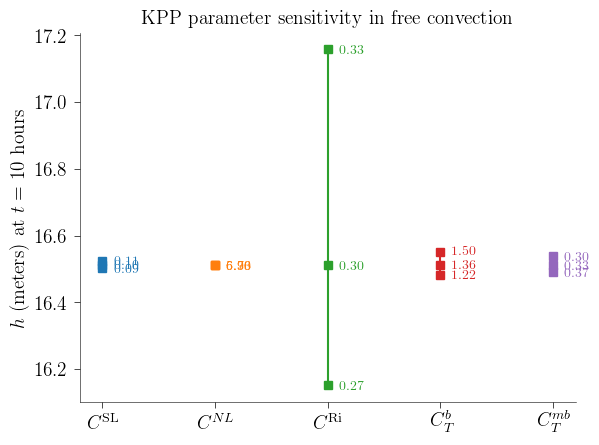

In [7]:
mixing_layer_depth_psens(parameters) = mixing_layer_depth(; dt=10*60, Δ=1, kpp_parameters=parameters)

function parameter_sensitivity(param_name, Δparam)
    
    defaults = KPP.Parameters()
    param₀ = getproperty(defaults, param_name)
    
    param₋ = param₀ - Δparam/2
    param₊ = param₀ + Δparam/2
    
    kw₋ = Dict(param_name=>param₋)
    kw₊ = Dict(param_name=>param₊)
    
    kpp_params₋ = KPP.Parameters(; kw₋...)
    kpp_params₊ = KPP.Parameters(; kw₊...)
    
    h₋ = mixing_layer_depth_psens(kpp_params₋)
    h₊ = mixing_layer_depth_psens(kpp_params₊)
    
    @show param_name param₋ param₊
    @show h₋ h₊
    
    return (h₊ - h₋) / Δparam
end

function sweep_parameter(paramname, paramvalues...)
    hs = []
    for val in paramvalues
        kw = Dict(paramname=>val)
        kpp_params = KPP.Parameters(; kw...)   
        push!(hs, mixing_layer_depth_psens(kpp_params))
    end
    
    return (h for h in hs)
end

study_params = [:CSL, :CNL, :CRi, :Cb_T, :Cmb_T]
param_labels = [L"C^{\mathrm{SL}}", L"C^{NL}", L"C^{\mathrm{Ri}}", L"C^b_T", L"C^{mb}_T"]
sensitivities = []
paramvalues = []
h₀ = mixing_layer_depth_psens(KPP.Parameters())
Δp = 0.1

defaults = KPP.Parameters()
for param in study_params
    param0 = getproperty(defaults, param)
    param₋ = (1-Δp)*param0
    param₊ = (1+Δp)*param0
    h₋, h₊ = sweep_parameter(param, param₋, param₊)
    
    push!(sensitivities, [h₋, h₀, h₊])
    push!(paramvalues, [param₋, param0, param₊])
end

fig, axs = subplots()
cornerspines()
defaultcolors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
ylabel("\$ h \$ (meters) at \$t=10\$ hours")
title("KPP parameter sensitivity in free convection")

for (i, s) in enumerate(sensitivities) 
    
    plot(i*ones(length(s)), s, "-s")
    
    for j in 1:length(s)
        txtstr = @sprintf("%.2f", paramvalues[i][j])
        text(i + 0.1, s[j], txtstr, verticalalignment="center", color=defaultcolors[i])
    end
    
end

xticks([i for i=1:length(sensitivities)])
axs.set_xticklabels(param_labels);